Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import t
from bisect import bisect
import scipy.io
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

Logistic Regression Test Result

test parameters : 

nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.05, number of data points = 12007, temperature = 1000.0, cutmh method error bournd = 0.005

In [2]:
# plot test result with Logistic Regression Model
# load data
f2 = h5py.File('logisticdata.mat');
samples1 = np.array(f2['newtestsamples']) 
samples2 = np.array(f2['oldtestsamples'])
samples3 = np.array(f2['cutmhsamples'])
samples4 = np.array(f2['adaptivemhsamples'])
samples5 = np.array(f2['cutmhwithsamples'])
size1 = np.array(f2['newtestsize'])
size2 = np.array(f2['oldtestsize'])
size3 = np.array(f2['cutmhsize'])
size4 = np.array(f2['adaptivemhsize'])
size5 = np.array(f2['cutmhwithsize'])
ll1 = np.array(f2['newtestll'])
ll2 = np.array(f2['oldtestll'])
ll3 = np.array(f2['cutmhll'])
ll4 = np.array(f2['adaptivemhll'])
ll5 = np.array(f2['cutmhwithll'])
acc1 = np.array(f2['newtestacc'])
acc2 = np.array(f2['oldtestacc'])
acc3 = np.array(f2['cutmhacc'])
acc4 = np.array(f2['adaptivemhacc'])
acc5 = np.array(f2['cutmhwithacc'])
bc1c2 = np.array(f2['adaptivemhbc1c2'])

162.52
2025.7866
7611.927
Accelerate over cut mh budget test is 12.4648449422
Accelerate over adaptive mh test is 46.8368631553


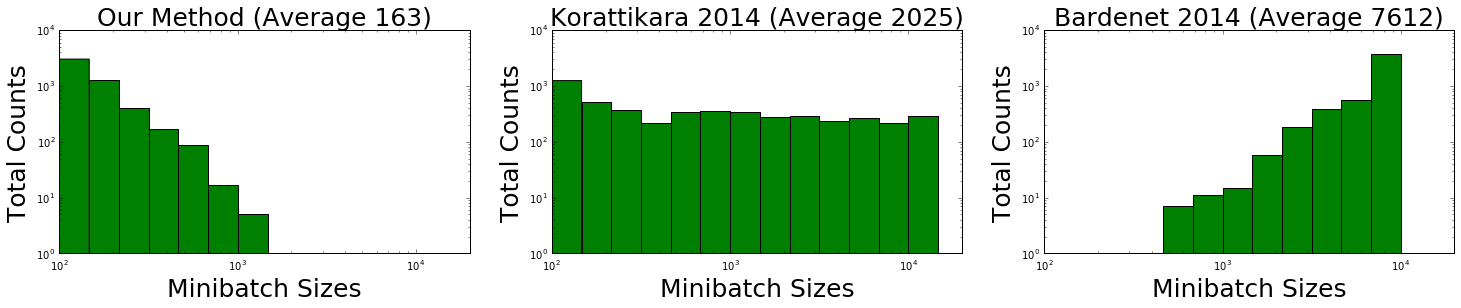

In [3]:
fig, axarr = plt.subplots(1,3, figsize=(25, 4))

axarr[0].set_title("Our Method (Average 163)", size=25)
axarr[0].hist(size1, bins=np.logspace(2, 6, 25),log=True, facecolor ='green')
axarr[0].set_xlabel("Minibatch Sizes", size=25)
axarr[0].set_ylabel("Total Counts", size=25)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([100,2*10**4])
axarr[0].set_ylim([1,10**4])
print np.mean(size1)

axarr[1].set_title("Korattikara 2014 (Average 2025)", size=25)
axarr[1].hist(size3, bins=np.logspace(2, 6, 25), facecolor ='green')
axarr[1].set_xlabel("Minibatch Sizes", size=25)
axarr[1].set_ylabel("Total Counts", size=25)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([100,2*10**4])
axarr[1].set_ylim([1,10**4])
print np.mean(size3)
axarr[2].set_title("Bardenet 2014 (Average 7612)", size=25)
axarr[2].hist(size4, bins=np.logspace(2, 6, 25), facecolor ='green')
axarr[2].set_xlabel("Minibatch Sizes", size=25)
axarr[2].set_ylabel("Total Counts", size=25)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_ylim([1,10**4])
axarr[2].set_xlim([100,2*10**4])

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)

fig.subplots_adjust(hspace=9)
print np.mean(size4)

print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0

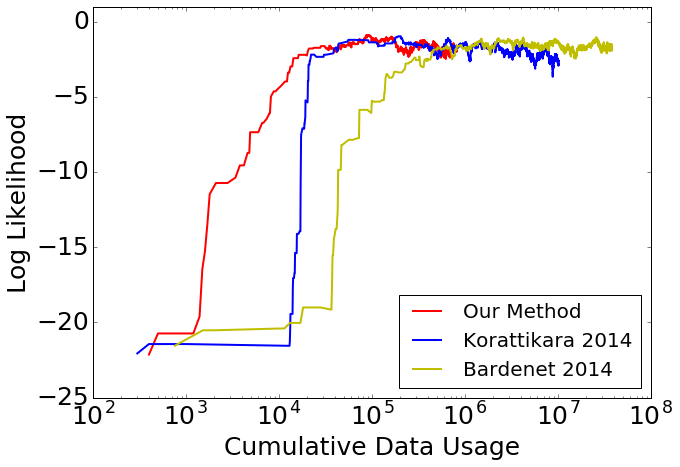

In [7]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(size1).reshape([5000,1]), ll1.reshape([5000,1]), 'r', label = 'Our Method', linewidth=2.0)
plt.hold()
plt.plot(np.cumsum(size3).reshape([5000,1]), ll3.reshape([5000,1]), 'b', label = 'Korattikara 2014', linewidth=2.0)
plt.plot(np.cumsum(size4).reshape([5000,1]), ll4.reshape([5000,1]), 'y', label = 'Bardenet 2014', linewidth=2.0)
axes = plt.gca()
axes.set_xlim([10**2, 10**8])
axes.set_ylim([-25,1])
axes.set_xscale("log")
axes.set_xlabel("Cumulative Data Usage", size = 25)
axes.set_ylabel("Log Likelihood", size = 25)
plt.legend(loc="lower right", prop={'size':20})
plt.show()
# plt.savefig('../figures/LogisticRegressionResult/ll_logistic.png', dpi=600)

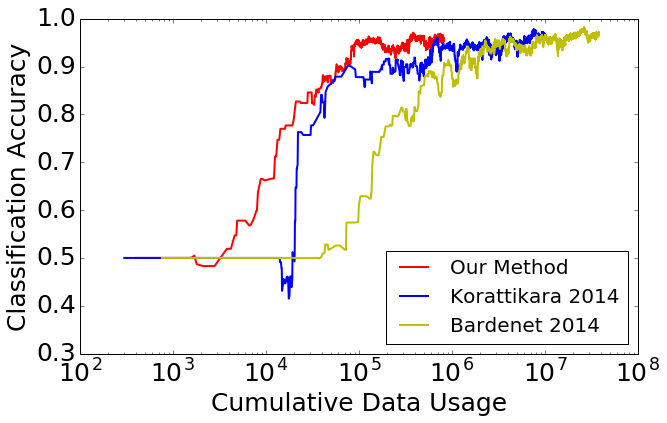

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(size1).reshape([5000,1]), acc1.reshape([5000,1]), 'r', label = 'Our Method', linewidth=2.0)
plt.hold()
plt.plot(np.cumsum(size3).reshape([5000,1]), acc3.reshape([5000,1]), 'b', label = 'Korattikara 2014', linewidth=2.0)
plt.plot(np.cumsum(size4).reshape([5000,1]), acc4.reshape([5000,1]), 'y', label = 'Bardenet 2014', linewidth=2.0)
axes = plt.gca()
axes.set_ylim([0.3,1])
axes.set_xscale("log")
axes.set_xlabel("Cumulative Data Usage", size = 25)
axes.set_ylabel("Classification Accuracy", size = 25)
plt.legend(loc="lower right", prop={'size':20})
plt.show()
# plt.savefig('../figures/LogisticRegressionResult/acc_logistic.png', dpi=600)

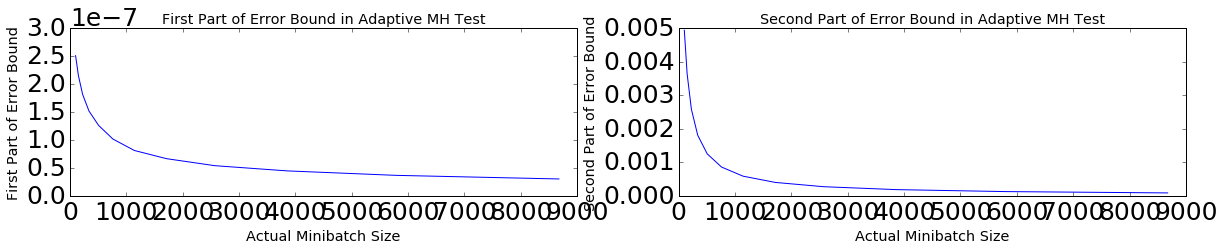

In [63]:
batch_size = bc1c2[:,0]
c1 = bc1c2[:,1]
c2 = bc1c2[:,2]

avg_c1 = np.zeros(int(np.max(batch_size)))
avg_c2 = np.zeros(int(np.max(batch_size)))
for b in range(100, int(np.max(batch_size))+1):
    index = [i for i in xrange(len(batch_size)) if batch_size[i] == b]
    if len(index) > 0:
        avg_c1[b-1] = np.mean(c1[index])
        avg_c2[b-1] = np.mean(c2[index])
    
index = [i for i in xrange(len(avg_c1)) if ( avg_c1[i] !=0 and avg_c2[i] != 0 )]
c1_final = avg_c1[index]
c2_final = avg_c2[index]
batchsize = np.linspace(1,int(np.max(batch_size)), int(np.max(batch_size)))
batch_final = batchsize[index]

fig, axarr = plt.subplots(1,2, figsize=(20, 3))
axarr[0].set_title("First Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[0].plot(batch_final, c1_final)
axarr[0].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[0].set_ylabel("First Part of Error Bound", size="x-large")

axarr[1].set_title("Second Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[1].plot(batch_final, c2_final)
axarr[1].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[1].set_ylabel("Second Part of Error Bound", size="x-large")
# plt.savefig('../figures/LogisticRegressionResult/first_second_part_logistic.png', dpi=800)